In [ ]:
import os
import zipfile
import pandas as pd
import zipfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Major_Project/Sorted3.zip', 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [ ]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Major_Project/testing.zip', 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [ ]:
import os
import pandas as pd

parent_folder = "/content/Sorted_images"
subfolders = ["Sorted_train"]
subsubfolders = ["with", "without"]

# Create an empty dataframe to store the image information
image_data = pd.DataFrame(columns=["image", "label"])

# Loop through the subfolders
for subfolder in subfolders:
    subfolder_path = os.path.join(parent_folder, subfolder)
    for i, subsubfolder in enumerate(subsubfolders):
        subsubfolder_path = os.path.join(subfolder_path, subsubfolder)
        for image_name in os.listdir(subsubfolder_path):
            image_path = os.path.join(subsubfolder_path, image_name)
            # Add the image information to the dataframe
            image_data = image_data.append({"image": image_path, "label": i}, ignore_index=True)

# Save the dataframe to a CSV file
image_data.to_csv("/content/train_images.csv", index=False)

<ipython-input-5-1edadbbd4400>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_data = image_data.append({"image": image_path, "label": i}, ignore_index=True)
<ipython-input-5-1edadbbd4400>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_data = image_data.append({"image": image_path, "label": i}, ignore_index=True)
<ipython-input-5-1edadbbd4400>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_data = image_data.append({"image": image_path, "label": i}, ignore_index=True)
<ipython-input-5-1edadbbd4400>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  image_data = image_data.append({"image": image_path, "label": i},

In [ ]:
import pandas as pd
from keras.layers import GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.applications import ResNet50
from keras.layers import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [ ]:
# Read the CSV file
df = pd.read_csv('/content/train_images.csv')
df['label'] = pd.Categorical(df['label'])

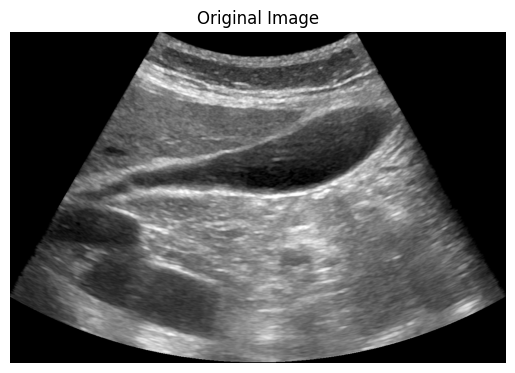

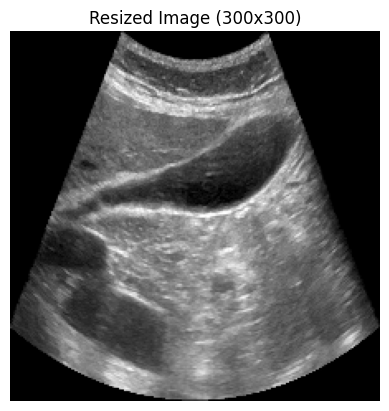

In [ ]:
import cv2
from matplotlib import pyplot as plt

# Load the image using OpenCV (cv2)
image_path = './Sorted_images/Sorted_train/without/im00007.jpg'  # Replace with your image path
image = cv2.imread(image_path)

# Display the original image
#plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.show()

# Resize the image (example: resizing to 300x300)
resized_image = cv2.resize(image, (224, 224))

# Display the resized image
#plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.title('Resized Image (300x300)')
plt.axis('off')
plt.show()

In [ ]:
# Split the dataframe into a training set and a test set
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

In [ ]:
# Create an ImageDataGenerator object to resize the images
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

In [ ]:
# Use the generator to read the images from disk, resize them, and create a generator for training and validation data
train_generator = datagen.flow_from_dataframe(dataframe=train_df, x_col='image', y_col='label', target_size=(224, 224), class_mode='raw')
val_generator = datagen.flow_from_dataframe(dataframe=test_df, x_col='image', y_col='label', target_size=(224, 224), class_mode='raw')

Found 494 validated image filenames.
Found 55 validated image filenames.


In [ ]:
# Create the ResNet50 model with pre-trained weights
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Freeze the layers of the ResNet50 model
for layer in resnet.layers:
    layer.trainable = False

In [ ]:
# Create a new model on top of ResNet50
x = resnet.output
x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=resnet.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint("model_at_epoch_{epoch}.h5", save_weights_only=False, save_freq='epoch')
history = model.fit_generator(train_generator, epochs=100, validation_data=val_generator, callbacks=[checkpoint])

<ipython-input-16-b1bca13eb3fc>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=100, validation_data=val_generator, callbacks=[checkpoint])


Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 0.7655 - accuracy: 0.4960

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 21s 570ms/step - loss: 0.7655 - accuracy: 0.4960 - val_loss: 0.6945 - val_accuracy: 0.5091
Epoch 2/100
16/16 [==============================] - 12s 792ms/step - loss: 0.6945 - accuracy: 0.5202 - val_loss: 0.6901 - val_accuracy: 0.4909
Epoch 3/100
16/16 [==============================] - 7s 399ms/step - loss: 0.6859 - accuracy: 0.5081 - val_loss: 0.6936 - val_accuracy: 0.4909
Epoch 4/100
16/16 [==============================] - 5s 283ms/step - loss: 0.6789 - accuracy: 0.5567 - val_loss: 0.6902 - val_accuracy: 0.5091
Epoch 5/100
16/16 [==============================] - 5s 287ms/step - loss: 0.6743 - accuracy: 0.5810 - val_loss: 0.6731 - val_accuracy: 0.6000
Epoch 6/100
16/16 [==============================] - 7s 448ms/step - loss: 0.6592 - accuracy: 0.6296 - val_loss: 0.6688 - val_accuracy: 0.6545
Epoch 7/100
16/16 [==============================] - 5s 286ms/step - loss: 0.6582 - accuracy: 0.6053 - val_loss: 0.6629 - val_accuracy: 0.6545
Epoch 8/1

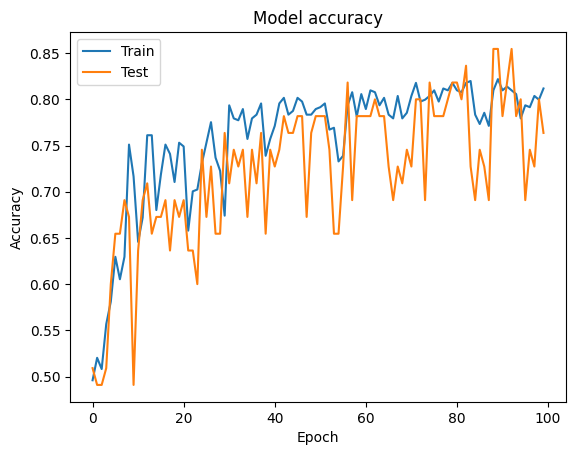

In [ ]:
# Plot the accuracy graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

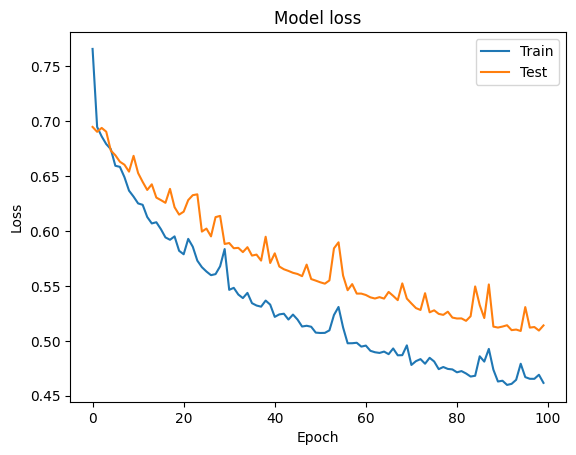

In [ ]:
# Plot the loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
# Evaluate the model on test data
model.evaluate_generator(val_generator)

<ipython-input-19-32d6950a4f83>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(val_generator)


[0.5139940977096558, 0.7636363506317139]

In [ ]:
# Save model
model.save('/content/drive/MyDrive/Major_Project/Resnet50/Resmodel.h5')

In [ ]:
# Load model
from keras.models import load_model
loaded_model = load_model('/content/drive/MyDrive/Major_Project/Resnet50/Resmodel.h5')

In [ ]:
# Predict the output
from tensorflow.keras.preprocessing import image
from PIL import Image
import numpy as np

img_path = "./Sorted_images/Sorted_train/with/im00143.jpg"

# Load the image and resize it to the shape required by the model
img = image.load_img(img_path,color_mode='rgb', target_size=(224,224))


# Convert the image to a numpy array
x = np.array(img)

# Add an extra dimension to the array to match the input shape of the model
x = np.expand_dims(x, axis=0)

# Normalize the image data
x = x / 255.

# Predict the class label of the image
predictions = loaded_model.predict(x)
print(predictions)

# Get the index of the class label with the highest probability
label = np.argmax(predictions)

print(label)
# Print class
if(label==0):
  print("With")
elif(label==1):
  print("Without")
else:
  print("wrong")

1/1 [==============================] - 1s 1s/step
[[0.6074205 0.3925795]]
0
With


In [ ]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np

true_labels = []
predicted_labels = []

main_directory = "./testing/Sorted_test/"

# Iterate through the folders in the main directory
for folder_name in os.listdir(main_directory):
    folder_path = os.path.join(main_directory, folder_name)

    if not os.path.isdir(folder_path):
        continue

    print(f"Predictions for images in folder: {folder_path}")

    # Iterate through the images in each folder
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)

        # Load the image and resize it to the required shape
        img = image.load_img(img_path, color_mode='rgb', target_size=(224, 224))

        # Convert the image to a numpy array and normalize
        x = np.array(img)
        x = np.expand_dims(x, axis=0)
        x = x / 255.

        predictions = loaded_model.predict(x)
        label = np.argmax(predictions)
        actual_label = 0 if folder_name == 'with' else 1

        true_labels.append(actual_label)
        predicted_labels.append(label)

        # Compare the predicted label with the actual label and printing result
        if label == actual_label:
            print(f"Image {filename}: Correct Prediction")
        else:
            print(f"Image {filename}: Incorrect Prediction")


true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
print(true_labels)
print(predicted_labels)


Predictions for images in folder: ./testing/Sorted_test/without
1/1 [==============================] - 8s 8s/step
Image im00018.jpg: Correct Prediction
1/1 [==============================] - 0s 25ms/step
Image im00389.jpg: Correct Prediction
1/1 [==============================] - 0s 24ms/step
Image im00328.jpg: Incorrect Prediction
1/1 [==============================] - 0s 25ms/step
Image im00224.jpg: Correct Prediction
1/1 [==============================] - 0s 27ms/step
Image im01077.jpg: Correct Prediction
1/1 [==============================] - 0s 25ms/step
Image im00823.jpg: Correct Prediction
1/1 [==============================] - 0s 25ms/step
Image im00613.jpg: Correct Prediction
1/1 [==============================] - 0s 24ms/step
Image im00482.jpg: Correct Prediction
1/1 [==============================] - 0s 26ms/step
Image im01116.jpg: Correct Prediction
1/1 [==============================] - 0s 25ms/step
Image im00997.jpg: Correct Prediction
1/1 [==============================]

Confusion Matrix:
[[31 11]
 [11 20]]


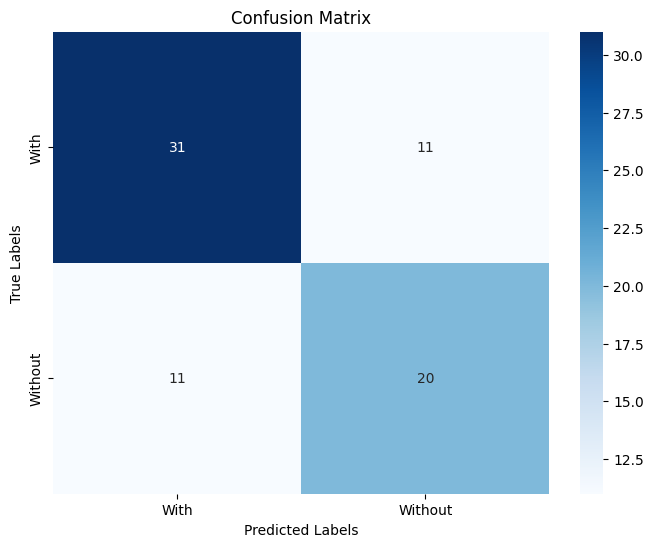

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Get the unique class labels
classes = np.unique(np.concatenate((true_labels, predicted_labels)))

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=classes)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

TP=cm[0][0]
FN=cm[0][1]
FP=cm[1][0]
TN=cm[1][1]

# Define class labels (replace with your actual class labels)
classess2 = ['With', 'Without']

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Create heatmap using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classess2, yticklabels=classess2, ax=ax)

# Set labels, title, and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

# Show the plot
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

PrecisionScore = TP / (FP + TP)
print('Precision: %.3f' % precision_score(true_labels,predicted_labels))
RecallScore = TP / (FN + TP)
print('Recall: %.3f' % recall_score(true_labels,predicted_labels))
AccuracyScore = (TP + TN)/ (TP + FN + TN + FP)
print('Accuracy: %.3f' % accuracy_score(true_labels,predicted_labels))
F1Score = 2 * PrecisionScore * RecallScore / (PrecisionScore + RecallScore)
print('F1 Score: %.3f' % f1_score(true_labels,predicted_labels))

Precision: 0.645
Recall: 0.645
Accuracy: 0.699
F1 Score: 0.645
